In [155]:
import pathlib

import gym
import torch
import numpy as np

from matplotlib import pyplot as plt

In [156]:
VIDEO_RECORD_DIR = pathlib.Path("../videos/reinforce/lunar_lander")

In [202]:
env = gym.make('LunarLander-v2', new_step_api=True)

In [203]:
class reinforce(torch.nn.Module):

    def __init__(self, policy: torch.nn.Module) -> None:
        super().__init__()
        self.policy = policy
    
    def forward(self, state):
        return self.policy(state)

class ActionReplayBuffer(torch.nn.Module):

    def __init__(self, gamma: float) -> None:
        super().__init__()
        self.gamma = gamma

        self.state_buffer = []
        self.action_buffer = []
        self.reward_buffer = []

    def __len__(self):
        return len(self.state_buffer)
    
    def push(self, state, action, reward):
        self.state_buffer.append(state)
        self.action_buffer.append(action)
        self.reward_buffer.append(reward)
    
    def sample(self):
        self.reward_buffer.reverse()

        for i in range(len(self.reward_buffer) - 1):
            self.reward_buffer[i + 1] = self.reward_buffer[i + 1] + ((self.gamma) * self.reward_buffer[i])

        self.reward_buffer.reverse()

        state_tensor = torch.tensor(self.state_buffer)
        action_tensor = torch.tensor(self.action_buffer)
        reward_tensor = torch.FloatTensor(self.reward_buffer)

        return state_tensor, action_tensor, reward_tensor

    def empty(self):
        self.state_buffer = []
        self.action_buffer = []
        self.reward_buffer = []

def action_multinomial(action_probabilities):
    output = torch.multinomial(action_probabilities, 1)
    return output.item()

def reinforce_loss(prob_batch, expected_returns_batch):
    return -torch.sum(torch.log(prob_batch) * expected_returns_batch) 


In [224]:
obs_size = env.observation_space.shape[0] 
n_actions = env.action_space.n  

model = torch.nn.Sequential(
             torch.nn.Linear(obs_size, 512),
             torch.nn.ReLU(),
             torch.nn.Linear(512, 256),
             torch.nn.ReLU(),
             torch.nn.Linear(256, n_actions),
             torch.nn.Softmax(dim=0)
     )

In [225]:
learning_rate = 0.0003

MAX_EPISODE_STEPS = 500
MAX_EPISODES = 50000

gamma = 0.6

In [226]:
agent = reinforce(model)
replay_buffer = ActionReplayBuffer(gamma)

optimizer = torch.optim.Adam(agent.parameters(), lr=learning_rate)

In [227]:
def torch_reinforce_train():
    score = []

    for trajectory in range(MAX_EPISODES + 1):
        state = env.reset()

        done = False
        ep_score = []
    
        for t in range(MAX_EPISODE_STEPS):
            torch_state = torch.from_numpy(state).float()
            action_probs = agent(torch_state)

            action = action_multinomial(action_probs)

            prev_state = state
            step_state = env.step(action)

            state, reward, done = step_state[0], step_state[1], step_state[2]

            replay_buffer.push(prev_state, action, reward)
            ep_score.append(reward)

            if done:
                break

        score.append(sum(ep_score))


        state_batch, action_batch, reward_batch = replay_buffer.sample()
        replay_buffer.empty()

        reward_batch = reward_batch / reward_batch.max()

        pred_batch = model(state_batch)
        prob_batch = pred_batch.gather(dim=1,index=action_batch
                 .long().view(-1,1)).squeeze()
    
        loss = reinforce_loss(prob_batch, reward_batch) 
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if trajectory % 100 == 0 and trajectory>0:
            print('Trajectory {}\tAverage Score: {:.2f}'.format(trajectory, sum(score[-50:-1]) / len(score[-50:-1])))
    
    return score    

In [228]:
score = torch_reinforce_train()

Trajectory 100	Average Score: -162.61
Trajectory 200	Average Score: -180.14
Trajectory 300	Average Score: -145.79
Trajectory 400	Average Score: -144.69
Trajectory 500	Average Score: -162.63
Trajectory 600	Average Score: -143.54
Trajectory 700	Average Score: -136.24
Trajectory 800	Average Score: -136.65
Trajectory 900	Average Score: -123.18
Trajectory 1000	Average Score: -165.02
Trajectory 1100	Average Score: -191.69
Trajectory 1200	Average Score: -195.99
Trajectory 1300	Average Score: -255.00
Trajectory 1400	Average Score: -320.15
Trajectory 1500	Average Score: -290.78
Trajectory 1600	Average Score: -328.03
Trajectory 1700	Average Score: -300.29
Trajectory 1800	Average Score: -312.95
Trajectory 1900	Average Score: -281.79
Trajectory 2000	Average Score: -331.12
Trajectory 2100	Average Score: -297.85
Trajectory 2200	Average Score: -312.87
Trajectory 2300	Average Score: -307.92
Trajectory 2400	Average Score: -283.87
Trajectory 2500	Average Score: -289.67
Trajectory 2600	Average Score: -27

KeyboardInterrupt: 

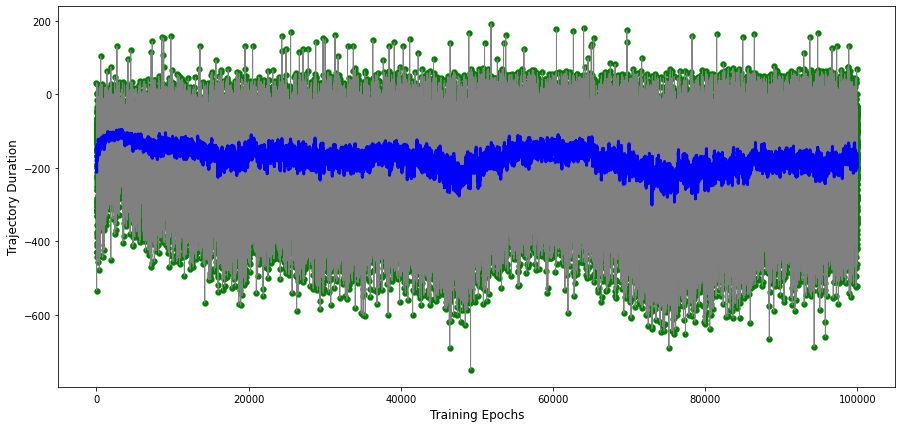

In [164]:
def running_mean(x):
    N=50
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y

score = np.array(score)
avg_score = running_mean(score)

plt.figure(figsize=(15,7))
plt.ylabel("Trajectory Duration",fontsize=12)
plt.xlabel("Training Epochs",fontsize=12)
plt.plot(score, color='gray' , linewidth=1)
plt.plot(avg_score, color='blue', linewidth=3)
plt.scatter(np.arange(score.shape[0]),score, 
            color='green' , linewidth=0.3)

In [248]:
from gym.wrappers import RecordVideo

def watch_agent(max_steps=500):
    env = gym.make('CartPole-v1', new_step_api=True)
    env = RecordVideo(env, video_folder=VIDEO_RECORD_DIR)
    state = env.reset()

    rewards = []

    for t in range(max_steps):
        pred = model(torch.from_numpy(state).float())
        action = torch.argmax(pred).item()

        step_state = env.step(action)
        state, reward, done = step_state[0], step_state[1], step_state[2]

        rewards.append(reward)

        if done:
            print("Reward:", sum([r for r in rewards]))
            break

    env.close()

In [249]:
watch_agent()

/Users/lulu/Worskpace/rl-journey/.venv/lib/python3.10/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/lulu/Worskpace/rl-journey/.venv/lib/python3.10/site-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /Users/lulu/Worskpace/rl-journey/videos/reinforce folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/Users/lulu/Worskpace/rl-journey/.venv/lib/python3.10/site-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/Users/lulu/Worskpace/rl-journey/.venv/lib/python3.10/site-pack

Reward: 500.0
